In [1]:
import importlib
import sys
import pickle
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset
import numpy as np
from datetime import datetime
import random

# import own modules
# ----------------------------------------------------------------------------
import plot_functions as pf
import torch_functions as tofu
import market_functions as mf
from util import timediff_d_h_m_s
from data_creator import data_creator
from agents import simple_agent
import FinMa



importlib.reload(sys.modules["FinMa"])
importlib.reload(FinMa)
importlib.reload(pf)
importlib.reload(mf)
importlib.reload(tofu)
importlib.reload(sys.modules['data_creator'])


from FinMa import FinMa, BSassets
from data_creator import data_creator

In [2]:
import config_2.config as config

mp = config.MARKET_PARAMS
pgp = config.PG_PARAMS
pgtp = config.PG_TRAIN_PARAMS
seed = config.SEED

if config.EVAL_PARAMS['use_wandb']:
    import wandb
    wandb.init(project=f"PPO_PG_{config.CONFIG_NO}", reinit=True)

In [3]:
# 1. Set `python` pseudo-random generator at a fixed value
random.seed(seed)

# 2. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 3. Set 'torch' pseudo-random generator at a fixed value
torch.manual_seed(seed)

### 1. Market environment

In [4]:
interest = mp["interest"]
npath = pgp["npath"]
ntime = mp["ntime"]
x0 = mp["x0"]
gamma = np.exp(-interest / ntime)

d = mp["d"]
s0 = mp["s0"]
mu = mp["mu"]
sig = mp["sig"]
cor = mp["cor"]
stds = np.sqrt(sig * np.eye(d))
Sigma = (stds @ cor @ stds).tolist()  # covariance structure of BM


additional_states = None
num_states = d + 2

# additional states besides time, asset and portfolio value
if 'additional_states' in mp.keys():
    if mp['additional_states'] is not None:
        additional_states = mp['additional_states']
        l = len(additional_states)
        if 'signX' in additional_states:
            num_states += 1
            l -= 1
        num_states += l*d

# additional tasks besides maximizing reward
additional_tasks = None
if 'additional_tasks' in mp.keys():
    additional_tasks = mp['additional_tasks']


In [5]:
if config.SAVE["model"]:
    import os
    import shutil

    foldername = os.path.join(
        f"config_{config.CONFIG_NO}",
        f"PG_" + datetime.now().strftime("%d-%m-%Y_%H:%M") + "/",
    )
    path = os.path.join(
        os.getcwd(),
        foldername,
    )
    os.makedirs(path)
    
    datapath = os.path.join(
        os.getcwd(),
        f"config_{config.CONFIG_NO}",
    )
    configpath = os.path.join(
        datapath,
        'config.py',
    )
    shutil.copyfile(configpath, os.path.join(path,'config_PG.py'))
elif config.SAVE["plots"] and config.SAVE["plot_path"] is None:
    print("Error: Please supply path to save plots in config file.")
    exit()

### 2. Set up Strategy NN

In [6]:
# initiate strategy
if additional_tasks is not None:
    model = tofu.Multitask_Actor_Net(dim=d,num_action=2*d,
     num_state=num_states, add_tasks=additional_tasks)
    num_outputs = 2 * d + model.num_add_tasks
else:
    num_outputs = 2*d
    model = tofu.Actor_Net(num_states, num_outputs)
    

In [7]:
# --------------------------------------------------------------------
# set parameters
# --------------------------------------------------------------------
loss = model.loss_fn if additional_tasks else torch.nn.L1Loss()
epochs = pgtp["epochs"]
batch_size = pgtp["batch_size"]

opt = optim.Adam(model.parameters(), lr=pgtp["lr"], weight_decay=pgtp["l2"])

hardmax = pgp["hardmax"]  # hardmax for action steps?
weights = pgp[
    "weights"
]  # how to weigh positive part and absolute value in MC estimate?

entropy_reg = None
if 'entropy_reg' in pgtp.keys():
    entropy_reg = pgtp['entropy_reg']

### 3. Initiate Market

In [8]:
asset_env = BSassets(
    interest=interest,
    s0=s0,
    sigma=Sigma,
    mu=mu,
    dim=d,
    ntime=ntime,
    npath=npath,
)
market_env = FinMa(
    pv0=x0,
    ntime=ntime,
    interest=interest,
    dim=d,
    npath=npath,
    asset_model=asset_env,
    additional_states=additional_states,
)

### 4. Training

In [9]:
# Take time for training
start = datetime.now()

In [10]:
# -----------------------------------------------------------------------------
# collect data and train:
# -----------------------------------------------------------------------------


data_points_per_timestep = [(10 + ntime - i) * 15 for i in range(ntime - 1)]

X = np.zeros((sum(data_points_per_timestep), 1))
S = np.zeros((sum(data_points_per_timestep), d))
T = np.zeros((sum(data_points_per_timestep), 1))
Y = np.zeros((sum(data_points_per_timestep), num_outputs))

    
for t_minus in range(pgp["max_t_minus"]):
    print(f"t_minus: {t_minus}\n")
    for i in range(data_points_per_timestep[t_minus]):
        temp_x_, temp_y = data_creator(
            model=model,
            asset_env=asset_env,
            r=interest,
            x0=x0,
            ntime=ntime,
            npath=npath,
            t_minus=t_minus,
            poss_action=market_env.poss_action,
            hardmax=hardmax,
            weights=weights,
            market_env=market_env,
        )
        temp_x, temp_s, temp_t = temp_x_
        index = sum(data_points_per_timestep[:t_minus]) + i
        X[index : index + 1, :] = temp_x
        S[index : index + 1, :] = temp_s
        T[index : index + 1, :] = temp_t
        Y[index : index + 1, :] = temp_y
    low = sum(data_points_per_timestep[:t_minus])
    up = sum(data_points_per_timestep[: t_minus + 1])

    if d == 1:
        # ceck how many labels are correct
        print(
            "for time t=",
            T[low, 0],
            " the percentage of correct labels is: ",
            100 * np.mean(X[low:up, :] * Y[low:up, 0:1] <= 0),
            "%",
        )
    # train on the new data points:
    tensor_input = torch.tensor(
            np.concatenate(
                (
                    T[low:up, :],
                    X[low:up, :],
                    S[low:up, :],
                ),
                axis=-1,
            ),
            dtype=torch.float,
        )
    if market_env is not None:
        tensor_input = market_env.create_additional_states(tensor_input)
    
    
    tensor_data = TensorDataset(
        tensor_input,
        torch.tensor(
            Y[low:up, :],
            dtype=torch.float,
        ),
    )
    
    tofu.torch_train(
        tensor_data,
        model,
        loss,
        opt,
        epochs,
        batch_size,
        entropy_reg=entropy_reg,
        log_wandb=config.EVAL_PARAMS['use_wandb'],
    )


t_minus: 0

Epoch 1
-------------------------------
[    0/  300] total_loss: 0.379933
[    0/  300] total_loss: 0.378654
[    0/  300] total_loss: 0.378830
[    0/  300] total_loss: 0.377220
[    0/  300] total_loss: 0.373366
[    0/  300] total_loss: 0.366942
[    0/  300] total_loss: 0.357441
[    0/  300] total_loss: 0.346747
[    0/  300] total_loss: 0.335698
[    0/  300] total_loss: 0.324934
[    0/  300] total_loss: 0.315273
[    0/  300] total_loss: 0.306501
[    0/  300] total_loss: 0.298391
[    0/  300] total_loss: 0.291304
[    0/  300] total_loss: 0.285104
[    0/  300] total_loss: 0.279456
[    0/  300] total_loss: 0.274073
[    0/  300] total_loss: 0.268653
[    0/  300] total_loss: 0.262595
[    0/  300] total_loss: 0.254489
[    0/  300] total_loss: 0.242579
[    0/  300] total_loss: 0.227310
[    0/  300] total_loss: 0.214772
[    0/  300] total_loss: 0.205643
[    0/  300] total_loss: 0.197606
[    0/  300] total_loss: 0.190346
[    0/  300] total_loss: 0.183832
[  

In [11]:
# take time after training
end = datetime.now()
print(
    "\nInstance Elapsed: {}d {}h:{}m:{}s".format(*timediff_d_h_m_s(end - start)),
    "(" + datetime.now().strftime("%H:%M %d-%m-%Y") + ")",
)


Instance Elapsed: 0d 2h:55m:29s (21:02 17-01-2023)


In [12]:
if config.SAVE["model"]:
    torch.save(model.state_dict(), path + "model")

### 5. Testing and visualizing

In [13]:
save = config.SAVE["plots"]

### 1d & 2d

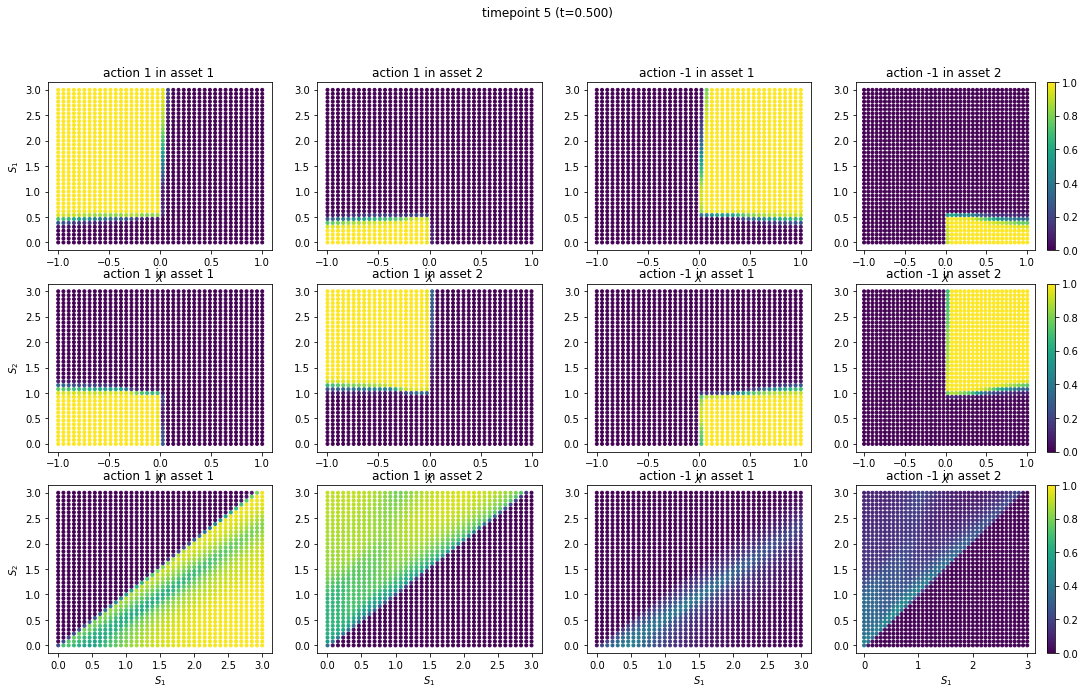

<Figure size 432x288 with 0 Axes>

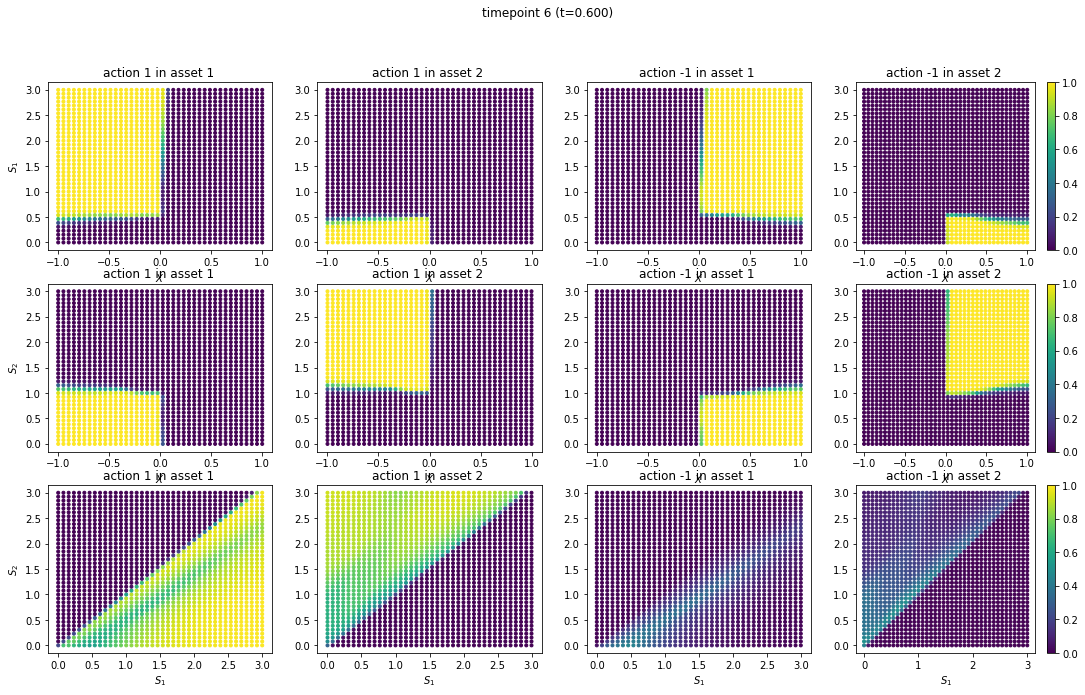

<Figure size 432x288 with 0 Axes>

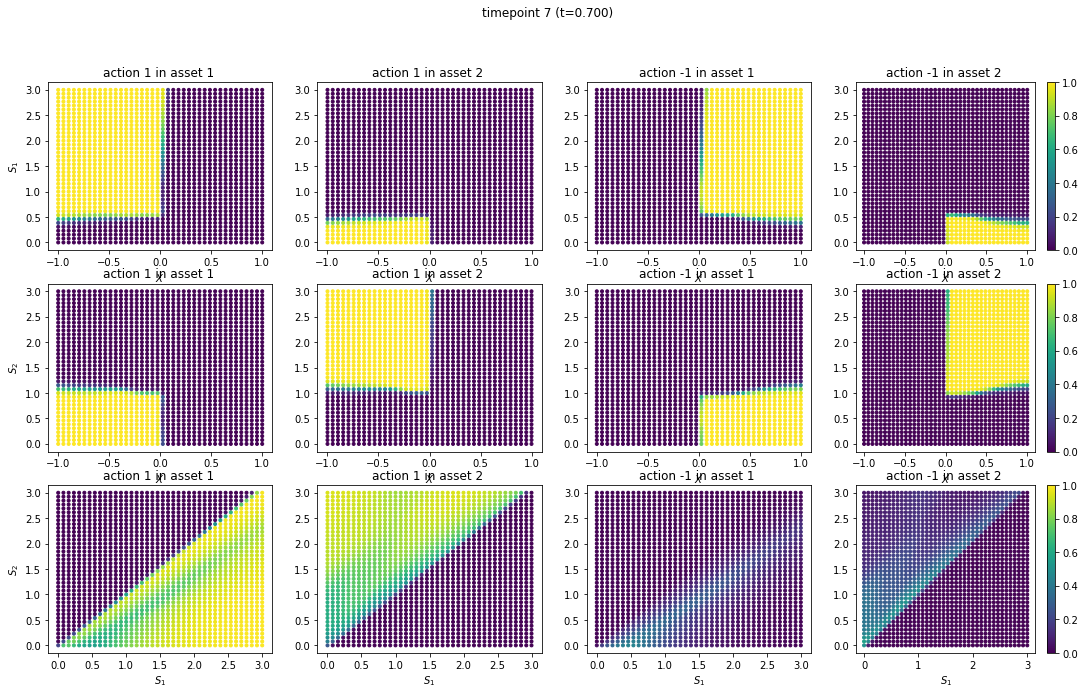

<Figure size 432x288 with 0 Axes>

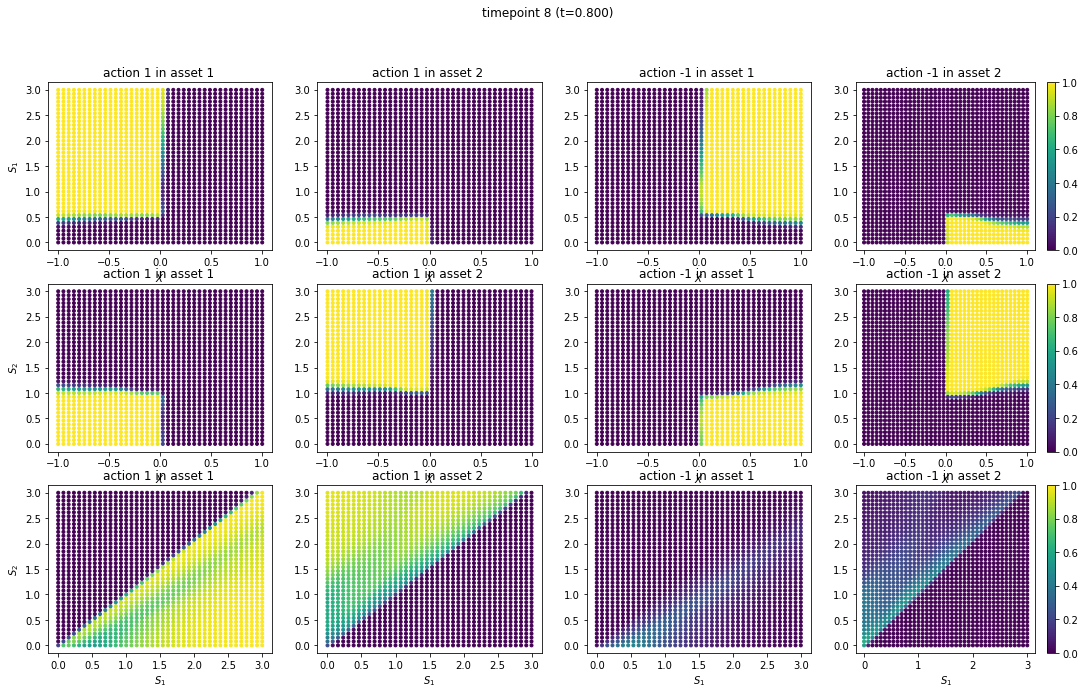

In [14]:
if d <= 2:
    pf.strategy_video(
        ntime=ntime,
        model=model,
        start=5,
        end=9,
        d=d,
        resolution=40,
        x_value=x0,
        xmax=x0+1,
        xmin=x0-1,
        s1_value=1,
        s2_value=0.5,
        market_env=market_env
    )

### Price and Value

In [15]:
mf.calc_price(
    model=model,
    asset_env=asset_env,
    x0=x0,
    s0=[1 for i in range(d)],
    npath=1000,
    poss_action=market_env.poss_action,
    ntime=ntime,
    r=interest,
    hardmax=True,
    market_env=market_env,
    weights=weights,
)

0.09333720296281703

In [16]:
if d > 1:
    f_test = np.vectorize(
        lambda x, y: mf.calc_price(
            model=model,
            asset_env=asset_env,
            x0=x0,
            s0=[x, y] + [1 for i in range(d - 2)],
            npath=1000,
            poss_action=market_env.poss_action,
            ntime=ntime,
            r=interest,
            hardmax=True,
            market_env=market_env,
            weights=weights,
        )
    )
else:
    f_test = np.vectorize(
        lambda x, y: mf.calc_price(
            model=model,
            asset_env=asset_env,
            x0=x,
            s0=y,
            npath=1000,
            poss_action=market_env.poss_action,
            ntime=ntime,
            r=interest,
            hardmax=True,
            market_env=market_env,
            weights=weights,
        )
    )

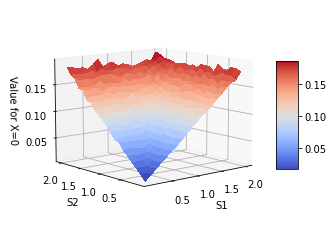

In [17]:
pf.plot_value(
    valuefun_vec=f_test,
    d=min(d, 2),
    smax=2,
    resolution=20,
    save=save,
    name=foldername,
)

### trade with trained agent

In [18]:
if d < 3:
    # PREDICT STRATEGY
    npath2plot = 1000

    x0path = np.expand_dims(np.repeat(x0, npath2plot), axis=1)

    # create new market data or load standard data set

    W, S2plot = mf.create_paths(
        filepath="",
        npath=npath2plot,
        ntime=ntime,
        Sigma=Sigma,
        mu=mu,
        r=interest,
        s0=np.ones((npath2plot, d)),
        retBM=True,
        save_paths=False,
    )

    # determine approximated strategy (samples from NN-probability for the prediction)
    q, p = mf.strategies(
        npath=npath2plot,
        ntime=ntime,
        d=d,
        model=model,
        S=S2plot,
        r=interest,
        poss_action=market_env.poss_action,
        hardmax=True,
        x0path=x0path,
        market_env=market_env,
    )

    print("finished predicting strategy\n")

    # portfolio value when trading with fitted strategy
    pv = mf.portfolio_value(
        q,
        S2plot,
        interest,
        x0path,
    )

finished predicting strategy



/scratch/users/hwutte/Documents/Research/Passport_Option/PPPO/plot_functions.py:502: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


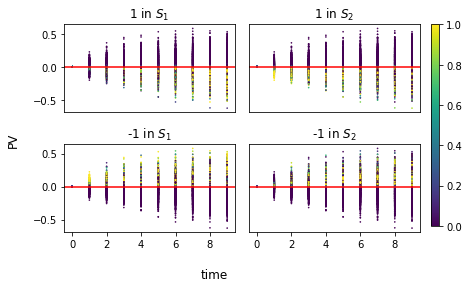

In [19]:
if d < 3:
    # Probability plots

    x = S2plot[:, :, 0]  # x-axis (however if timescale==True, x-axis will be time)
    timescale = True
    y = pv  # y-axis

    strat = p
    omegas = range(0, npath2plot, 2 ** 0)  # paths to plot

    pf.plot_probabilities(
        d=d,
        timerange=ntime,
        omegas=omegas,
        y=y,
        strategy_process=strat,
        poss_action=market_env.poss_action,
        x=x,
        timescale=timescale,
        xlabel="S",  # will be overwritten if timescale==True
        ylabel="PV",
        connectpaths=False,
        save=True,
        name=foldername,
    )  # set to true if paths should be connected by lines